In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, sgd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from matplotlib import pyplot as plt
import numpy as np
import time
import pandas as pd
from collections import defaultdict
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from PIL import Image

class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels= 32, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(in_channels = 64, out_channels= 128, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(in_channels = 128, out_channels= 256, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(in_channels = 256, out_channels= 512, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.AvgPool2d(kernel_size = 3),
        )
        
        self.linear = nn.Linear(512,512)

    def forward(self, image):
        # get the 3D feature map from image
        feature_map = self.linear(self.cnn(image).view(image.size(0), -1))
        return feature_map
    
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, num_layers, vocabulary, max_seq_length=128):

        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size * 3 , hidden_size, num_layers = num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()
        self.attention = BahdanauAttention(hidden_size)

        self.max_seg_length = max_seq_length
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.vocab = dict(vocabulary)

    def forward(self, encoder_outputs, target_tensor=None, teacher_forcing_prob = 0.5):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(self.vocab["<SOS>"])
        decoder_hidden = (encoder_outputs.view(1,encoder_outputs.shape[0],encoder_outputs.shape[1]),encoder_outputs.view(1,encoder_outputs.shape[0],encoder_outputs.shape[1]))
        decoder_outputs = []
        attentions = []

        for i in range(self.max_seg_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if torch.rand(1).item() > teacher_forcing_prob :
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_repr):
        embedded =  (self.embedding(input))
        query = hidden[0].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_repr.unsqueeze(1))
        input_lstm = torch.cat((embedded, context), dim=-1)
        input_lstm = torch.concat((encoder_repr.unsqueeze(1), input_lstm), dim=-1)

        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)

        return output, hidden, attn_weights
    
    
class LatexNet2(nn.Module):

    def __init__(self,hidden_size, vocab_size, num_layers, vocabulary, max_seq_length=128):
        #hidden_size == embed_size
        super(LatexNet2, self).__init__()
        self.encoder = Encoder(hidden_size)
        self.decoder = AttnDecoderRNN(hidden_size, vocab_size, num_layers, vocabulary, max_seq_length)
    
    def forward(self, image, formula = None, teacher_forcing_prob = 0.5):
        encoder_outputs = self.encoder(image)
        decoder_outputs, decoder_hidden, _ = self.decoder(encoder_outputs, formula, teacher_forcing_prob)
        return decoder_outputs, decoder_hidden, encoder_outputs
    def predict(self,image):
        encoder_outputs = self.encoder(image.to(device))
        decoder_outputs, decoder_hidden, _ = self.decoder(encoder_outputs, teacher_forcing_prob = 0)
        return decoder_outputs.argmax(-1), decoder_outputs
        

In [52]:
def make_vocabulary(paths):
    vocab = defaultdict(lambda : -1)
    vocab["[PAD]"] = 0
    vocab["<SOS>"] = 1
    vocab["<EOS>"] = 2
    run_index = 3
    for file in paths:
        csv_file = pd.read_csv(file)
        for formula in csv_file['formula'].values:
            formula_split = formula.split()
            for character in formula_split:
                if character not in vocab:
                    vocab[character] = run_index
                    run_index += 1
    return vocab

In [53]:
def load_data(path_to_images, path_to_csv, vocabulary, max_length_formula = 128):
    images = []
    labels = []
    lengths = []
    trans = transforms.ToTensor()
    label_csv = pd.read_csv(path_to_csv)
    label_split = [label_csv.iloc[i]['formula'].split() for i in range(len(label_csv))]
    print(len(label_split))
    x = [True if len(label) <= max_length_formula-2 else False for label in label_split]
    label_csv = label_csv.loc[x]
    label_split2 = label_split
    label_split = []
    for label in label_split2:
        if len(label) <= max_length_formula-2:
            label_split.append(label)
    t = time.time()
    images = ([(trans(Image.open(os.path.join(path_to_images, fname)).resize((224, 224)))) for fname in label_csv['image']])
    print(f"Images done in :{time.time() -t:.3}s")
    lengths = np.array([len(label)+2 for label in label_split])
    labels = np.zeros((len(label_split), max_length_formula))
    labels[:,0] = vocabulary['<SOS>']
    for i in range(len(label_split)):
        labels[i,1:len(label_split[i])+1] = np.array([vocabulary[char] for char in label_split[i]])
        labels[i,len(label_split[i])+1] = vocabulary['<EOS>']
    return images, labels, vocabulary, lengths

In [54]:
class image_latex_dataset2(torch.utils.data.Dataset):

    def __init__(self, images, labels, vocabulary, lengths, max_length_formula = 128):
        self.images, self.labels, self.vocabulary, self.lengths = images, labels, vocabulary, lengths
        self.inverse_vocabulary = {v:k for k,v in self.vocabulary.items()}

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if self.images[idx].shape[0] == 1:
            self.images[idx] = torch.cat((self.images[idx], self.images[idx], self.images[idx]), dim=0)
        return self.images[idx], self.labels[idx], self.lengths[idx]

In [22]:
vocab_train = make_vocabulary(['col_774_A4_2023/SyntheticData/train.csv','col_774_A4_2023/HandwrittenData/train_hw.csv'])

In [28]:
t = time.time()
train_data_load = load_data('col_774_A4_2023/SyntheticData/images','col_774_A4_2023/SyntheticData/train.csv',vocab_train)
print(time.time() -t)
train_data2 = image_latex_dataset2(train_data_load[0],train_data_load[1],train_data_load[2],train_data_load[3])

75000
Images done in :8.07e+02s
810.2831854820251


In [31]:
t = time.time()
vocab_test = make_vocabulary(['col_774_A4_2023/SyntheticData/test.csv'])
test_data_load = load_data('col_774_A4_2023/SyntheticData/images','col_774_A4_2023/SyntheticData/test.csv',vocab_test)
print(time.time() -t)
test_data2 = image_latex_dataset2(test_data_load[0],test_data_load[1],test_data_load[2],test_data_load[3])

8907
Images done in :94.9s
95.8395345211029


In [33]:
t = time.time()
vocab_val = make_vocabulary(['col_774_A4_2023/SyntheticData/val.csv'])
val_data_load = load_data('col_774_A4_2023/SyntheticData/images','col_774_A4_2023/SyntheticData/val.csv',vocab_val)
print(time.time() -t)
val_data2 = image_latex_dataset2(val_data_load[0],val_data_load[1],val_data_load[2],val_data_load[3])

10000
Images done in :1.18e+02s
119.38315391540527


In [55]:
test_loader2 = DataLoader(test_data2, batch_size=128, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=256, shuffle=True)
val_loader2 = DataLoader(val_data2, batch_size=128, shuffle=True)

In [56]:
model = LatexNet2(512, len(vocab_train), 1, vocab_train)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index = 0)
model.to(device)
model.train()

LatexNet2(
  (encoder): Encoder(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (15): AvgPool2d(kernel_size=3, stride=3, padding=0)
    )
    (linear): Linear(in_features=512, out_feat

In [57]:
#training loop
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
path = f'LatexNetSaved_{dt_string}'
os.mkdir(path)
prev_loss = float('inf')
stochastic_losses = []
best_val_loss = float('inf')
epoch_val_loss = []
use_adaptive_tf = False
print(f"Saving models to {path}")
teacher_forcing_prob = 0.5

Saving models to LatexNetSaved_27_11_2023_21_11_41


In [42]:
decoderOutput.permute(0,2,1).shape

torch.Size([256, 565, 128])

In [ ]:
teacher_forcing_prob = 0.5

In [58]:
for epoch in range(1,51):
    model.train()
    epoch_train_loss = []
    epoch_time = time.time()
    for i, (imgs, labls, lenghts) in enumerate(train_loader2):
        imgs = imgs.to(device)
        labls = labls.long().to(device)
        optimizer.zero_grad()
        decoderOutput, decoderHidden, encoderOutput = model(imgs, labls, teacher_forcing_prob)
        decoderOutput.shape
        loss = criterion(decoderOutput.reshape(-1, len(vocab_train)), labls.long().reshape(-1))
        loss.backward()
        epoch_train_loss.append(loss.item())
        stochastic_losses.append(loss.item())
        optimizer.step()
        if i % 100 == 0:
            plt.figure(figsize=(30,18))
            plt.plot(stochastic_losses)
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(["Training Loss"])
            plt.savefig("StochasticLoss.png")
            print("Epoch: {} Iteration: {} Loss: {}".format(epoch, i, loss.item()))
            plt.close()
    torch.save(model.state_dict, os.path.join(path,f'model_train_{epoch}.pth'))
    print("Epoch: {} Loss: {} Time :{} | TFP : ".format(epoch, np.mean(epoch_train_loss), time.time() -epoch_time), teacher_forcing_prob)

Epoch: 1 Iteration: 0 Loss: 6.33901834487915
Epoch: 1 Iteration: 100 Loss: 3.2691147327423096
Epoch: 1 Iteration: 200 Loss: 2.9519927501678467
Epoch: 1 Loss: 3.2591548526496217 Time :101.0072979927063 | TFP :  0.5
Epoch: 2 Iteration: 0 Loss: 2.9300875663757324
Epoch: 2 Iteration: 100 Loss: 2.772155284881592
Epoch: 2 Iteration: 200 Loss: 2.9415605068206787
Epoch: 2 Loss: 2.9073506815391674 Time :100.42513728141785 | TFP :  0.5
Epoch: 3 Iteration: 0 Loss: 2.874453544616699
Epoch: 3 Iteration: 100 Loss: 2.8593344688415527
Epoch: 3 Iteration: 200 Loss: 2.7515532970428467
Epoch: 3 Loss: 2.8034287360676546 Time :100.410817861557 | TFP :  0.5
Epoch: 4 Iteration: 0 Loss: 2.8204898834228516
Epoch: 4 Iteration: 100 Loss: 2.728649854660034
Epoch: 4 Iteration: 200 Loss: 2.5858418941497803
Epoch: 4 Loss: 2.723907571089895 Time :100.3859794139862 | TFP :  0.5
Epoch: 5 Iteration: 0 Loss: 2.708970785140991
Epoch: 5 Iteration: 100 Loss: 2.7112107276916504
Epoch: 5 Iteration: 200 Loss: 2.572737455368042

In [84]:
import math
from nltk import word_tokenize
from collections import Counter
from nltk.util import ngrams


class BLEU(object):
    @staticmethod
    def compute(candidate, references, weights):
        candidate = [c.lower() for c in candidate]
        references = [[r.lower() for r in reference] for reference in references]

        p_ns = (BLEU.modified_precision(candidate, references, i) for i, _ in enumerate(weights, start=1))
        s = math.fsum(w * math.log(p_n) for w, p_n in zip(weights, p_ns) if p_n)

        bp = BLEU.brevity_penalty(candidate, references)
        return bp * math.exp(s)

    @staticmethod
    def modified_precision(candidate, references, n):
        counts = Counter(ngrams(candidate, n))

        if not counts:
            return 0

        max_counts = {}
        for reference in references:
            reference_counts = Counter(ngrams(reference, n))
            for ngram in counts:
                max_counts[ngram] = max(max_counts.get(ngram, 0), reference_counts[ngram])

        clipped_counts = dict((ngram, min(count, max_counts[ngram])) for ngram, count in counts.items())

        return sum(clipped_counts.values()) / sum(counts.values())
    
    @staticmethod
    def brevity_penalty(candidate, references):
        c = len(candidate)
        # r = min(abs(len(r) - c) for r in references)
        r = min(len(r) for r in references)

        if c > r:
            return 1
        else:
            return math.exp(1 - r / c)


In [86]:
test_vocab_inverse = {v:k for (k,v) in vocab_test.items()}
train_vocab_inverse = {v:k for (k,v) in vocab_train.items()}
val_vocab_inverse = {v:k for (k,v) in vocab_val.items()}

In [103]:
model.eval()
model.to(device)
predict = []
true_out = []
img_c = []
for data in test_loader2:
    decoder_outputs = model.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
        s = []
        img_c.append(img)
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict.append(' '.join(s))
        s = []
        for i in true_sent:
            if test_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(test_vocab_inverse[i.item()])
        true_out.append(' '.join(s[1:]))
        
# TEST
scorer = BLEU()
overall = 0
for gt, pred in zip(true_out, predict):
    gt = gt.split()
    pred = pred.split()
    overall += BLEU.compute(pred,[gt], weights=[1/4, 1/4, 1/4, 1/4])

print("Macro Bleu : ", overall/len(predict))

Macro Bleu :  0.30910763631077726


In [88]:
model.eval()
model.to(device)
predict = []
true_out = []
img_c = []
for data in val_loader2:
    decoder_outputs = model.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
        s = []
        img_c.append(img)
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict.append(' '.join(s))
        s = []
        for i in true_sent:
            if val_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(val_vocab_inverse[i.item()])
        true_out.append(' '.join(s[1:]))
        
# TEST
scorer = BLEU()
overall = 0
for gt, pred in zip(true_out, predict):
    gt = gt.split()
    pred = pred.split()
    overall += BLEU.compute(pred,[gt], weights=[1/4, 1/4, 1/4, 1/4])

print("Macro Bleu : ", overall/len(predict))

Macro Bleu :  0.3059862926997581


In [81]:
true_out[10]

'$ \\partial _ { z } ( Z ^ { - 1 } \\partial _ { \\bar { z } } \\theta ) = 0 $'

In [90]:
model.eval()
model.to(device)
predict = []
true_out = []
img_c = []
for data in train_loader2:
    decoder_outputs = model.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
        s = []
        img_c.append(img)
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict.append(' '.join(s))
        s = []
        for i in true_sent:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        true_out.append(' '.join(s[1:]))
        
# TEST
scorer = BLEU()
overall = 0
for gt, pred in zip(true_out, predict):
    gt = gt.split()
    pred = pred.split()
    overall += BLEU.compute(pred,[gt], weights=[1/4, 1/4, 1/4, 1/4])

print("Macro Bleu : ", overall/len(predict))

Macro Bleu :  0.35883977512806525


$ \left. A _ { 0 } ( { ) \right| _ { q = 0 } = 0 } = 0 \ . $

$ \psi _ { E } ( q ) \bigr | _ { q = L } \ = \ 0 \ \ . $


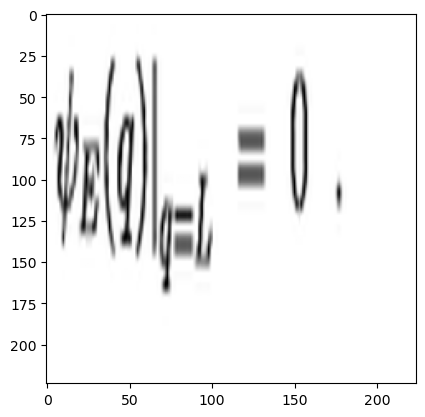

In [108]:
j = 167
print(predict[j])
print()
print(true_out[j])
plt.imshow(img_c[j].permute(1,2,0))

In [109]:
t = time.time()
vocab_val_hw  = make_vocabulary(['col_774_A4_2023/HandwrittenData/val_hw.csv'])
val_data_load_hw = load_data('col_774_A4_2023/HandwrittenData/images/train','col_774_A4_2023/HandwrittenData/val_hw.csv',vocab_val_hw,128)
print(time.time() -t)
val_dataHW = image_latex_dataset2(val_data_load_hw[0],val_data_load_hw[1],val_data_load_hw[2],val_data_load_hw[3])

1000
Images done in :21.0s
21.262426614761353


In [111]:
vocab_val_hw_inv = {v:k for (k,v) in vocab_val_hw.items()}

In [121]:
val_hw_loader = DataLoader(val_dataHW, batch_size=128, shuffle=True)
model.eval()
model.to(device)
predict = []
true_out = []
img_c = []
for data in val_hw_loader:
    decoder_outputs = model.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
        s = []
        img_c.append(img)
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict.append(' '.join(s))
        s = []
        for i in true_sent:
            if vocab_val_hw_inv[i.item()] == "<EOS>":
                break
            s.append(vocab_val_hw_inv[i.item()])
        true_out.append(' '.join(s[1:]))

In [122]:
#VALIDATION
scorer = BLEU()
overall = 0
for gt, pred in zip(true_out, predict):
    gt = gt.split()
    pred = pred.split()
    overall += BLEU.compute(pred,[gt], weights=[1/4, 1/4, 1/4, 1/4])

print("Macro Bleu : ", overall/len(predict))

Macro Bleu :  0.3057386526019732


In [126]:
t = time.time()
train_data_loadHw = load_data('col_774_A4_2023/HandwrittenData/images/train','col_774_A4_2023/HandwrittenData/train_hw.csv',vocab_train)
print(time.time() -t)
train_dataHw = image_latex_dataset2(train_data_load[0],train_data_load[1],train_data_load[2],train_data_load[3])

9000
Images done in :1.57e+02s
157.1575002670288


In [139]:
LatX_HW = LatexNet2(512, len(vocab_train), 1, vocab_train)
optimizer_hw = Adam(LatX_HW.parameters(), lr=0.001)
criterion_hw = nn.CrossEntropyLoss(ignore_index = 0)
LatX_HW.to(device)
LatX_HW.train()

LatX_HW.load_state_dict(torch.load(f'LatexNetSaved_27_11_2023_21_11_41/model_train_{50}.pth')())

<All keys matched successfully>

In [140]:
LatX_HW.eval()
LatX_HW.to(device)
predict = []
true_out = []
img_c = []
for data in val_loader2:
    decoder_outputs = LatX_HW.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
        s = []
        img_c.append(img)
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict.append(' '.join(s))
        s = []
        for i in true_sent:
            if val_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(val_vocab_inverse[i.item()])
        true_out.append(' '.join(s[1:]))
        
# TEST
scorer = BLEU()
overall = 0
for gt, pred in zip(true_out, predict):
    gt = gt.split()
    pred = pred.split()
    overall += BLEU.compute(pred,[gt], weights=[1/4, 1/4, 1/4, 1/4])

print("Macro Bleu : ", overall/len(predict))

Macro Bleu :  0.30598629269975763


In [141]:
def load_data_subHW(path_to_images, path_to_csv):
    images = []
    index = []
    trans = transforms.ToTensor()
    label_csv = pd.read_csv(path_to_csv)
    images = ([(trans(Image.open(os.path.join(path_to_images, fname)).resize((224, 224)))) for fname in label_csv['image']])
    for i in range(len(images)):
        if images[i].shape[0] == 1:
            images[i] = torch.cat([images[i], images[i], images[i]], dim = 0)
    return images

In [142]:
t = time.time()
sub_dataHW = load_data_subHW('col_774_A4_2023/HandwrittenData/images/test','sample_sub.csv')
print(time.time() -t)

74.69114279747009


In [146]:
testHW_Loader = DataLoader(sub_dataHW, batch_size=128, shuffle=False)

In [151]:
for i in testHW_Loader:
    print(i.shape)
    break

torch.Size([128, 3, 224, 224])


In [219]:
LatxNetFine.load_state_dict(torch.load('LatexNetFine_28_11_2023_00_13_23/model_train_fine_20.pth')())

<All keys matched successfully>

In [220]:
LatxNetFine.eval()
LatxNetFine.to(device)
LatxNetFine.max_seg_length = 1000
predict = []
true_out = []
img_c = []
for data in testHW_Loader:
    decoder_outputs = LatxNetFine.forward(data.to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for i,sent in enumerate(decoder_outputs):
        s = []
        img_c.append(data[i])
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict.append(' '.join(s))

$ - \frac { 7 } { 3 } $


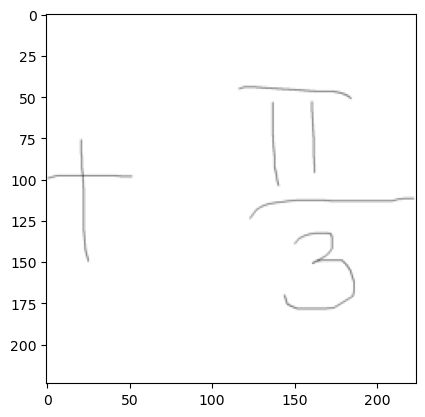

In [223]:
j = 190
print(predict[j])
plt.imshow(img_c[j].permute(1,2,0))

In [195]:
csv = pd.read_csv('sample_sub.csv')

In [196]:
csv = pd.read_csv('sample_sub.csv')
new_dict = {'image':[], 'formula':[]}
for i in range(len(predict)):
    new_dict['image'].append(csv['image'][i])
    new_dict['formula'].append(predict[i])

In [198]:
csv = pd.read_csv('sample_sub.csv')
new_dict = {'image':[], 'formula':[]}
for i in range(len(predict)):
    new_dict['image'].append(csv['image'][i])
    new_dict['formula'].append(predict[i])
new_pd = pd.DataFrame(new_dict)
new_pd.to_csv('preds/sample_sub4.csv', index = False)

In [176]:
t = time.time()
train_data_loadHw = load_data('col_774_A4_2023/HandwrittenData/images/train','col_774_A4_2023/HandwrittenData/train_hw.csv',vocab_train)
print(time.time() -t)
train_dataHw = image_latex_dataset2(train_data_loadHw[0],train_data_loadHw[1],train_data_loadHw[2],train_data_loadHw[3])

9000
Images done in :77.2s
77.62962913513184


In [178]:
train_loader_hw = DataLoader(train_dataHw, batch_size = 256, shuffle = True)

In [179]:
LatxNetFine = LatexNet2(512, len(vocab_train), 1, vocab_train)
LatxNetFine.load_state_dict(torch.load(f'LatexNetSaved_27_11_2023_21_11_41/model_train_{50}.pth')())
optimizer_hw = Adam(LatxNetFine.parameters(), lr=0.001)
criterion_hw = nn.CrossEntropyLoss(ignore_index = 0)
LatxNetFine.to(device)
LatxNetFine.train()
LatxNetFine.load_state_dict(torch.load(f'LatexNetSaved_27_11_2023_21_11_41/model_train_{50}.pth')())

<All keys matched successfully>

In [180]:
#training loop
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
path_hw = f'LatexNetFine_{dt_string}'
os.mkdir(path_hw)
prev_loss = float('inf')
stochastic_losses = []
best_val_loss = float('inf')
epoch_val_loss = []
use_adaptive_tf = False
print(f"Saving models to {path_hw}")
teacher_forcing_prob = 0.5

Saving models to LatexNetFine_28_11_2023_00_13_23


In [199]:
for epoch in range(51,71):
    LatxNetFine.train()
    epoch_train_loss = []
    epoch_time = time.time()
    for i, (imgs, labls, lenghts) in enumerate(train_loader_hw):
        imgs = imgs.to(device)
        labls = labls.long().to(device)
        optimizer_hw.zero_grad()
        decoderOutput, decoderHidden, encoderOutput = LatxNetFine(imgs, labls, teacher_forcing_prob)
        decoderOutput.shape
        loss = criterion_hw(decoderOutput.reshape(-1, len(vocab_train)), labls.long().reshape(-1))
        loss.backward()
        epoch_train_loss.append(loss.item())
        stochastic_losses.append(loss.item())
        optimizer_hw.step()
        if i % 100 == 0:
            plt.figure(figsize=(30,18))
            plt.plot(stochastic_losses)
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(["Training Loss"])
            plt.savefig("StochasticLoss_hw.png")
            print("Epoch: {} Iteration: {} Loss: {}".format(epoch, i, loss.item()))
            plt.close()
    torch.save(LatxNetFine.state_dict, os.path.join(path_hw,f'model_train_fine_{epoch}.pth'))
    print("Epoch: {} Loss: {} Time :{} | TFP : ".format(epoch, np.mean(epoch_train_loss), time.time() -epoch_time), teacher_forcing_prob)

Epoch: 51 Iteration: 0 Loss: 0.06654726713895798
Epoch: 51 Loss: 0.08666430123978192 Time :17.642337799072266 | TFP :  0.5
Epoch: 52 Iteration: 0 Loss: 0.07914729416370392
Epoch: 52 Loss: 0.0775065700420075 Time :11.172361612319946 | TFP :  0.5
Epoch: 53 Iteration: 0 Loss: 0.0749819278717041
Epoch: 53 Loss: 0.07629373245355156 Time :11.18888545036316 | TFP :  0.5
Epoch: 54 Iteration: 0 Loss: 0.07587683200836182
Epoch: 54 Loss: 0.07170986580765909 Time :11.176464080810547 | TFP :  0.5
Epoch: 55 Iteration: 0 Loss: 0.07073302567005157
Epoch: 55 Loss: 0.07777529820385906 Time :11.162496566772461 | TFP :  0.5
Epoch: 56 Iteration: 0 Loss: 0.07095178216695786
Epoch: 56 Loss: 0.06263520754873753 Time :11.174270153045654 | TFP :  0.5
Epoch: 57 Iteration: 0 Loss: 0.047268860042095184
Epoch: 57 Loss: 0.057971472593231335 Time :11.173411846160889 | TFP :  0.5
Epoch: 58 Iteration: 0 Loss: 0.043525755405426025
Epoch: 58 Loss: 0.04866823279816243 Time :11.263727903366089 | TFP :  0.5
Epoch: 59 Iterat

In [175]:
train_loader_hw.__len__()

285

In [177]:
t = time.time()

val_data_loadHw = load_data('col_774_A4_2023/HandwrittenData/images/train','col_774_A4_2023/HandwrittenData/val_hw.csv',vocab)
print(time.time() -t)
val_dataHw = image_latex_dataset2(val_data_load[0],val_data_load[1],val_data_load[2],val_data_load[3])

NameError: name 'vocab' is not defined

In [224]:
while(input()):
    break

k
